In [149]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [150]:
import matplotlib

In [151]:
import os
import logging
import argparse
import glob
import json
from collections import Counter

import numpy as np
from matplotlib.ticker import StrMethodFormatter

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
import pandas as pd
from astropy.table import Table  # for NSA
from astropy import units as u
from sklearn.metrics import confusion_matrix, roc_curve
from PIL import Image
from scipy.stats import binom
from IPython.display import display, Markdown

from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error

from shared_astro_utils import astropy_utils, matching_utils
from zoobot.estimators import make_predictions, bayesian_estimator_funcs
from zoobot.tfrecord import read_tfrecord
from zoobot.uncertainty import discrete_coverage
from zoobot.estimators import input_utils, losses
from zoobot.tfrecord import catalog_to_tfrecord
from zoobot.active_learning import metrics, simulated_metrics, acquisition_utils, check_uncertainty, simulation_timeline, run_estimator_config
from zoobot import label_metadata
from zoobot.estimators import losses


In [152]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)


In [153]:
label_cols = label_metadata.gz2_label_cols
questions = label_metadata.gz2_questions


# state_loc = 'results/temp/gz2_all_q_warm_active/iteration_0/state.pickle'
# label_cols = label_metadata.gz2_label_cols
# questions = label_metadata.gz2_questions

version = 'gz2'
schema = losses.Schema(label_cols, questions, version=version)

{smooth-or-featured, indices 0 to 1, asked after None: (0, 1), disk-edge-on, indices 2 to 3, asked after <zoobot.estimators.losses.Answer object at 0x7f76279edc10>: (2, 3), has-spiral-arms, indices 4 to 5, asked after <zoobot.estimators.losses.Answer object at 0x7f76279ede90>: (4, 5), bar, indices 6 to 7, asked after <zoobot.estimators.losses.Answer object at 0x7f76279ede90>: (6, 7), bulge-size, indices 8 to 11, asked after <zoobot.estimators.losses.Answer object at 0x7f76279ede90>: (8, 11), something-odd, indices 12 to 13, asked after None: (12, 13), how-rounded, indices 14 to 16, asked after <zoobot.estimators.losses.Answer object at 0x7f76279edfd0>: (14, 16), bulge-shape, indices 17 to 19, asked after <zoobot.estimators.losses.Answer object at 0x7f76279ed310>: (17, 19), spiral-winding, indices 20 to 22, asked after <zoobot.estimators.losses.Answer object at 0x7f7638aea590>: (20, 22), spiral-count, indices 23 to 28, asked after <zoobot.estimators.losses.Answer object at 0x7f7638aea59

In [154]:
os.chdir('/home/walml/repos/zoobot')

In [155]:
m = 0
active = True

if active:
    it0 = pd.read_csv(f'temp/gz2_allq_opt4_it0_m{m}.csv')
    it1 = pd.read_csv(f'temp/gz2_allq_opt4_it1_m{m}.csv')
    it2 = pd.read_csv(f'temp/gz2_allq_opt4_it2_m{m}.csv')
else:
    it0 = pd.read_csv(f'temp/gz2_allq_baseline_it0_m{m}.csv')
    it1 = pd.read_csv(f'temp/gz2_allq_baseline_it1_m{m}.csv')
    it2 = pd.read_csv(f'temp/gz2_allq_baseline_it2_m{m}.csv')

In [156]:
it_list = [it0, it1, it2]

In [157]:
assert np.all(it0['dr7objid'] == it1['dr7objid'])

In [158]:
catalog_loc = 'data/gz2/gz2_master_catalog.csv'
catalog = pd.read_csv(catalog_loc, dtype={'subject_id': str})  # original catalog
catalog['file_loc'] = catalog['local_png_loc'].apply(lambda x: '/media/walml/beta/galaxy_zoo/gz2' + x[32:])
catalog['id_str'] = catalog['dr7objid'].apply(lambda x: 'dr7objid_' + str(x))

In [159]:
label_cols = label_metadata.gz2_label_cols

In [160]:
n_models = len(it_list)

In [161]:
concentration_cols = [col + '_concentration' for col in label_cols]
concentration_mean_cols = [col + '_concentration_mean' for col in label_cols]

In [162]:
for it in it_list:
    for col in concentration_cols:
        it[col] = it[col].apply(lambda x: np.array(json.loads(x)))

In [163]:
def get_predictions(it):
    answer_predictions = []
    for col_n in range(len(concentration_cols)):
        answer_predictions.append(np.stack(list(it[concentration_cols[col_n]].values)))
    return np.stack(answer_predictions).transpose(1, 0, 2)

In [164]:
id_strs=it0['dr7objid']

answer_cols = [a.text for a in schema.answers]
labels = it0[answer_cols].values  # same for all

predictions_list = [it[concentration_mean_cols].values for it in it_list]  # over all dropouts
# predictions_list = [get_predictions(it)[:, :, 0] for it in it_list]  # first dropout only



In [165]:
loss_list = []
for predictions in predictions_list:
    loss = losses.multiquestion_loss(
        tf.constant(labels, dtype=tf.float32),
        tf.constant(predictions, dtype=tf.float32),
        schema.question_index_groups
    )
    loss_list.append(loss)

In [166]:
overall_df = pd.DataFrame(data=[{'iteration': n, 'loss': loss.numpy().mean()} for n, loss in enumerate(loss_list)])

In [167]:
overall_df

,iteration,loss
0,0,1.826795
1,1,1.815390
2,2,1.822699


(1.8, 1.87)

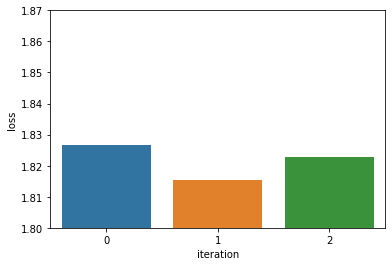

In [168]:
fig, ax = plt.subplots()
sns.barplot(data=overall_df, x='iteration', y='loss')
ax.set_ylim([1.8, 1.87])

In [169]:
data = []
for iteration_n in range(3):
    for question_n, question in enumerate(schema.questions):
        data.append({'model': m, 'iteration': iteration_n, 'question': question.text, 'loss': loss_list[iteration_n].numpy()[:, question_n].mean()})

In [170]:
df = pd.DataFrame(data=data)

In [171]:
mean_per_q = df.groupby('question').agg({'loss': 'min'}).reset_index()
mean_per_q['min_loss'] = mean_per_q['loss']
del mean_per_q['loss']

In [172]:
df = pd.merge(df, mean_per_q, on='question', how='inner')

In [173]:
df['loss_delta'] = df['loss'] - df['min_loss'] + .02

In [174]:
if m == 0:
    df_0 = df
if m == 1:
    df_1 = df
if m == 2:
    df_2 = df

In [175]:
assert False

AssertionError: 

In [177]:
df_all = pd.concat([df_0, df_1, df_2])

(1.8, 1.9)

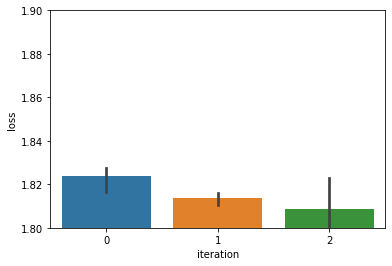

In [178]:
fig, ax = plt.subplots()
sns.barplot(data=df_all.groupby(['iteration', 'model']).agg('mean').reset_index(), x='iteration', y='loss')
ax.set_ylim([1.8, 1.9])

In [179]:
df_all.groupby(['iteration', 'model']).agg('mean')

loss  min_loss  loss_delta
iteration model                                
0         0      1.826795  1.804040    0.042755
          1      1.827574  1.800913    0.046662
          2      1.816609  1.796166    0.040443
1         0      1.815389  1.804040    0.031349
          1      1.815792  1.800913    0.034879
          2      1.810343  1.796166    0.034177
2         0      1.822699  1.804040    0.038658
          1      1.805240  1.800913    0.024327
          2      1.798410  1.796166    0.022243

(1.8, 1.9)

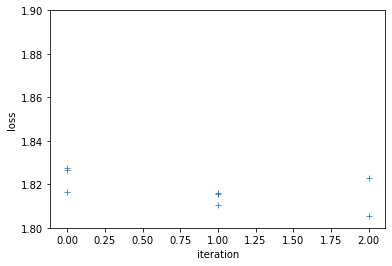

In [180]:
fig, ax = plt.subplots()
sns.scatterplot(data=df_all.groupby(['iteration', 'model']).agg('mean').reset_index(), x='iteration', y='loss', marker='+')
ax.set_ylim([1.8, 1.9])

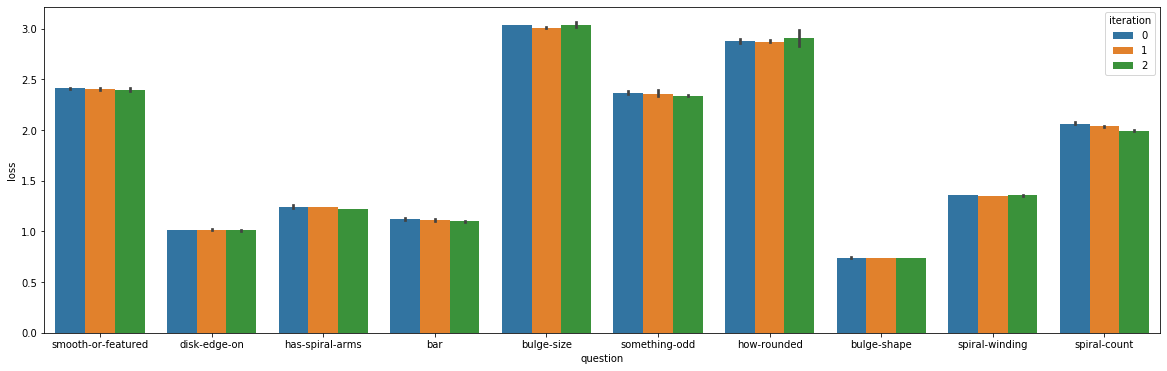

In [181]:

fig, ax = plt.subplots(figsize=(20, 6))
sns.barplot(data=df_all, hue='iteration', x='question', y='loss')
# ax.set_ylim([1.8, 1.87])

In [182]:
active_qs = df_all[df_all['question'].isin(['smooth-or-featured', 'has-spiral-arms', 'bar', 'bulge-size'])].groupby(['question', 'iteration']).agg({'loss': 'mean'})
active_qs

loss
question           iteration          
bar                0          1.122381
                   1          1.114117
                   2          1.097759
bulge-size         0          3.034356
                   1          3.009887
                   2          3.037622
has-spiral-arms    0          1.242532
                   1          1.239975
                   2          1.220858
smooth-or-featured 0          2.411787
                   1          2.404501
                   2          2.398430

In [ ]:

fig, ax = plt.subplots(figsize=(20, 6))
sns.barplot(data=df_all, hue='iteration', x='question', y='loss_delta')
# ax.set_ylim([1.8, 1.87])

In [ ]:
fig, axes = plt.subplots(nrows=len(schema.questions), figsize=(10, 16), sharex=True)
_, bins = np.histogram(np.linspace(0, 10.), bins=30)

for q_n, question in enumerate(schema.questions):
    ax = axes[q_n]
    for iteration_n, loss in enumerate(loss_list):
        ax.hist(loss[:, q_n], bins=bins, alpha=.6, density=True, label='Iteration {}'.format(iteration_n), histtype='step')
        ax.set_xlabel(question.text)
    #     ax.set_xlim([0, 1])
    ax.legend()
fig.tight_layout()